<a href="https://colab.research.google.com/github/ElisabethShah/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 132
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [1]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [2]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=46.9247338312202, pvalue=6.462841665184595e-11)


In [3]:
sample = np.random.normal(0, 5, 1000)
print(normaltest(sample))

NormaltestResult(statistic=0.2002409075198343, pvalue=0.9047284335307719)


In [4]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [5]:
# Taking requests! Come to lecture with a topic or problem and we'll try it.

import pandas as pd

df = pd.read_csv('https://math.tntech.edu/e-stat/DASL/popularkids.txt', sep='\t')
df.head()

,Gender,Grade,Age,Race,Urban.Rural,School,Goals,Grades,Sports,Looks,Money
0,boy,5,11,White,Rural,Elm,Sports,1,2,4,3
1,boy,5,10,White,Rural,Elm,Popular,2,1,4,3
2,girl,5,11,White,Rural,Elm,Popular,4,3,1,2
3,girl,5,11,White,Rural,Elm,Popular,2,3,4,1
4,girl,5,10,White,Rural,Elm,Popular,4,2,1,3


In [6]:
df.isnull().sum()

Gender         0
Grade          0
Age            0
Race           0
Urban.Rural    0
School         0
Goals          0
Grades         0
Sports         0
Looks          0
Money          0
dtype: int64

In [7]:
table_observed = pd.crosstab(df['Goals'], df['Grade'])
table_observed

Grade,4,5,6
Goals,,,
Grades,63,88,96
Popular,31,55,55
Sports,25,33,32


In [8]:
table_observed_w_marg = pd.crosstab(df['Goals'], df['Grade'], margins=True)
table_observed_w_marg.head()

Grade,4,5,6,All
Goals,,,,
Grades,63,88,96,247
Popular,31,55,55,141
Sports,25,33,32,90
All,119,176,183,478


In [9]:
table_observed_w_marg['All']

Goals
Grades     247
Popular    141
Sports      90
All        478
Name: All, dtype: int64

In [10]:
table_observed_w_marg.T['All']

Grade
4      119
5      176
6      183
All    478
Name: All, dtype: int64

In [11]:
table_observed_w_marg['All'].values[:-1]

array([247, 141,  90])

In [12]:
np.outer(table_observed_w_marg['All'].values[:-1], 
         table_observed_w_marg.T['All'].values[:-1])/table_observed_w_marg.T['All'].values[-1]

array([[61.4916318 , 90.94560669, 94.56276151],
       [35.10251046, 51.91631799, 53.98117155],
       [22.40585774, 33.13807531, 34.45606695]])

In [13]:
goals_totals = table_observed_w_marg['All'].values[:-1]
goals_totals

array([247, 141,  90])

In [14]:
grade_totals = table_observed_w_marg.T['All'].values[:-1]
grade_totals

array([119, 176, 183])

In [0]:
assert goals_totals.sum() == grade_totals.sum()

In [16]:
grade_totals.sum()

478

In [17]:
expected = np.outer(goals_totals, grade_totals)/grade_totals.sum()
expected

array([[61.4916318 , 90.94560669, 94.56276151],
       [35.10251046, 51.91631799, 53.98117155],
       [22.40585774, 33.13807531, 34.45606695]])

In [18]:
table_expected = pd.DataFrame(expected)
table_expected.columns = table_observed.columns
table_expected.index = table_observed.index
table_expected

Grade,4,5,6
Goals,,,
Grades,61.491632,90.945607,94.562762
Popular,35.102510,51.916318,53.981172
Sports,22.405858,33.138075,34.456067


In [19]:
deviation = table_observed - table_expected
deviation

Grade,4,5,6
Goals,,,
Grades,1.508368,-2.945607,1.437238
Popular,-4.102510,3.083682,1.018828
Sports,2.594142,-0.138075,-2.456067


In [20]:
table_observed

Grade,4,5,6
Goals,,,
Grades,63,88,96
Popular,31,55,55
Sports,25,33,32


In [21]:
deviation_sq = deviation**2
deviation_sq

Grade,4,5,6
Goals,,,
Grades,2.275175,8.676599,2.065654
Popular,16.830592,9.509095,1.038011
Sports,6.729574,0.019065,6.032265


In [22]:
fraction = deviation_sq/table_expected
fraction

Grade,4,5,6
Goals,,,
Grades,0.037000,0.095404,0.021844
Popular,0.479470,0.183162,0.019229
Sports,0.300349,0.000575,0.175071


In [23]:
fraction.values.sum()

1.3121045153815976

In [24]:
table_observed

Grade,4,5,6
Goals,,,
Grades,63,88,96
Popular,31,55,55
Sports,25,33,32


In [25]:
from scipy.stats import chi2_contingency

chi2, p, df, expect = chi2_contingency(table_observed)
print(f'chi2 stat: {chi2}')
print(f'p-value: {p}')
print(f'df: {df}')
print(f'expected freq: {expect}')

chi2 stat: 1.3121045153815976
p-value: 0.8593185000807877
df: 4
expected freq: [[61.4916318  90.94560669 94.56276151]
 [35.10251046 51.91631799 53.98117155]
 [22.40585774 33.13807531 34.45606695]]


##Confidence intervals

In [26]:
import scipy.stats as stats
import numpy as np

#confidence_interval = [lower_bound, upper_bound]

coinflips = np.random.binomial(n=1, p=.501, size=10000000)
print(coinflips[:20])

[0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 0 0]


In [27]:
stats.ttest_1samp(coinflips, 0.5)

Ttest_1sampResult(statistic=5.740175578535904, pvalue=9.458116230791467e-09)

In [28]:
stats.ttest_1samp(coinflips, 0.6)

Ttest_1sampResult(statistic=-626.7163667898918, pvalue=0.0)

In [29]:
coinflips_100 = np.random.binomial(n=1, p=.5, size=100)
coinflips_1000 = np.random.binomial(n=1, p=.5, size=1000)

print("100 Coinflips Standard Deviation:", np.std(coinflips_100, ddof=1))
print("1000 Coinflips Standard Deviation:", np.std(coinflips_1000, ddof=1))

100 Coinflips Standard Deviation: 0.4824181513244218
1000 Coinflips Standard Deviation: 0.49928778103243054


In [0]:
def my_stdev(sample_data):
  mu = sample_data.mean()
  diff = sample_data - mu
  diff_sq = diff**2
  stdev = np.sqrt(diff_sq.sum()/(len(sample_data)-1))
  return stdev

In [31]:
delta_100 = my_stdev(coinflips_100)/np.sqrt(100)
delta_100

0.048241815132442176

In [32]:
delta_1000 = my_stdev(coinflips_1000)/np.sqrt(1000)
delta_1000

0.015788865959538965

In [33]:
coinflips_1000.mean() - delta_1000

0.453211134040461

In [34]:
coinflips_1000.mean() + delta_1000

0.48478886595953896

In [35]:
coinflips_100.mean() - delta_100

0.5917581848675578

In [36]:
coinflips_100.mean() + delta_100

0.6882418151324422

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [37]:
!curl 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.names'

1. Title: 1984 United States Congressional Voting Records Database

2. Source Information:
    (a) Source:  Congressional Quarterly Almanac, 98th Congress, 
                 2nd session 1984, Volume XL: Congressional Quarterly Inc. 
                 Washington, D.C., 1985.
    (b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
    (c) Date: 27 April 1987 

3. Past Usage
   - Publications
     1. Schlimmer, J. C. (1987).  Concept acquisition through 
        representational adjustment.  Doctoral dissertation, Department of 
        Information and Computer Science, University of California, Irvine, CA.
        -- Results: about 90%-95% accuracy appears to be STAGGER's asymptote
     - Predicted attribute: party affiliation (2 classes)

4. Relevant Information:
      This data set includes votes for each of the U.S. House of
      Representatives Congressmen on the 16 key votes identified by the
      CQA.  The CQA lists nine different types of votes: voted for, paired
      

In [38]:
names = ['party', 'handicapped-infants', 'water-project-cost-sharing', 
           'adoption-of-the-budget-resolution', 'physician-fee-freeze', 
           'el-salvador-aid', 'religious-groups-in-schools', 
           'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 
           'mx-missile', 'immigration', 'synfuels-corporation-cutback', 
           'education-spending', 'superfund-right-to-sue', 'crime', 
           'duty-free-exports', 'export-administration-act-south-africa']

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'voting-records/house-votes-84.data', header=None,
                 names=names, na_values='?')
df.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [39]:
df = df.replace({'n': 0, 'y': 1})
df.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [40]:
df.describe()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,423.000000,387.000000,424.000000,424.000000,420.000000,424.000000,421.000000,420.00000,413.000000,428.000000,414.000000,404.000000,410.000000,418.000000,407.000000,331.000000
mean,0.442080,0.503876,0.596698,0.417453,0.504762,0.641509,0.567696,0.57619,0.501211,0.504673,0.362319,0.423267,0.509756,0.593301,0.427518,0.812689
std,0.497222,0.500632,0.491140,0.493721,0.500574,0.480124,0.495985,0.49475,0.500605,0.500563,0.481252,0.494690,0.500516,0.491806,0.495327,0.390752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
overall_mean = np.nanmean(df.drop('party', axis=1).values)
overall_std = np.nanstd(df.drop('party', axis=1).values)
overall_serr = overall_std / np.sqrt(df.drop('party', axis=1).dropna().size)
print(overall_mean, overall_std, overall_serr)

0.5208587088915956 0.499564724798875 0.008199507749486157


In [42]:
stats.norm.interval(0.95, loc=overall_mean, scale=overall_serr)

(0.5047879690116457, 0.5369294487715455)

In [43]:
republican_df = df[df['party']=='republican']
republican_mean = np.nanmean(republican_df.drop('party', axis=1).values)
republican_std = np.nanstd(republican_df.drop('party', axis=1).values)
republican_serr = republican_std / np.sqrt(republican_df.drop('party', axis=1).dropna().size)
print(republican_mean, republican_std, republican_serr)

0.5205318732890105 0.49957826431825875 0.012017985224393029


In [44]:
stats.norm.interval(0.95, loc=republican_mean, scale=republican_serr)

(0.49697705508246565, 0.5440866914955553)

In [45]:
democrat_df = df[df['party']=='democrat']
democrat_mean = np.nanmean(democrat_df.drop('party', axis=1).values)
democrat_std = np.nanstd(democrat_df.drop('party', axis=1).values)
democrat_serr = democrat_std / np.sqrt(democrat_df.drop('party', axis=1).dropna().size)
print(democrat_mean, democrat_std, democrat_serr)

0.5210670655696834 0.49955598159593956 0.011215362869227592


In [46]:
stats.norm.interval(0.95, loc=democrat_mean, scale=democrat_serr)

(0.49908535827244954, 0.5430487728669173)

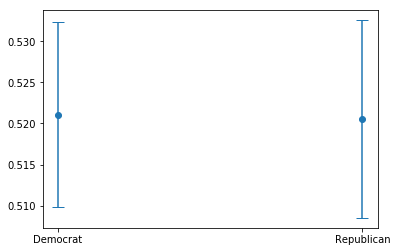

In [47]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'errorbar.capsize': 6})

plt.errorbar(['Democrat', 'Republican'], 
             [democrat_mean, republican_mean],
             yerr=[democrat_serr,
                   republican_serr],
             fmt='o')
plt.show()

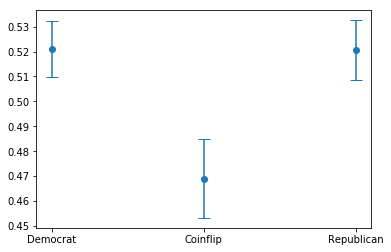

In [48]:
plt.errorbar(['Democrat', 'Coinflip', 'Republican'], 
             [democrat_mean,  coinflips_1000.mean(), republican_mean],
             yerr=[democrat_serr,
                   delta_1000,
                   republican_serr],
             fmt='o')
plt.show()

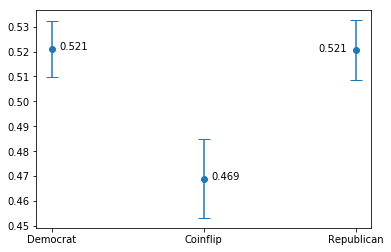

In [49]:
plt.errorbar(['Democrat', 'Coinflip', 'Republican'], 
             [democrat_mean,  coinflips_1000.mean(), republican_mean],
             yerr=[democrat_serr,
                   delta_1000,
                   republican_serr],
             fmt='o')
plt.text(x=0.05, y=democrat_mean-0.0005, s='{:.3f}'.format(democrat_mean))
plt.text(x=1.05, y=coinflips_1000.mean()-0.0005, s='{:.3f}'.format(coinflips_1000.mean()))
plt.text(x=1.75, y=republican_mean-0.0005, s='{:.3f}'.format(republican_mean))
plt.show()

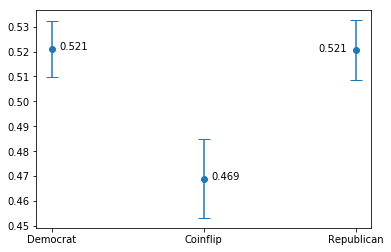

In [50]:
plt.errorbar(['Democrat', 'Coinflip', 'Republican'], 
             [democrat_mean,  coinflips_1000.mean(), republican_mean],
             yerr=[democrat_serr,
                   delta_1000,
                   republican_serr],
             fmt='o')
plt.text(x=0.05, y=democrat_mean-0.0005, s='{:.3f}'.format(democrat_mean))
plt.text(x=1.05, y=coinflips_1000.mean()-0.0005, s='{:.3f}'.format(coinflips_1000.mean()))
plt.text(x=1.75, y=republican_mean-0.0005, s='{:.3f}'.format(republican_mean))
plt.show()

####Interpret the confidence interval - what does it tell you about the data and its distribution?



## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)